___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" />
    
    
### <font color='navy'> Modelado de pronóstico de series de tiempo.

**Nombres:** José Luis Almendarez González, Marcela Quintero Pérez.

**Fecha:** 15 de mayo del 2025.

**Expediente** : 717644.

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [Repositorio del proyecto - Señales EEG](https://github.com/Marcelaqprz/mnl_proyecto)

# Cerebro en Serie: Modelado y Clasificación de Señales EEG con Técnicas Clásicas y Neuronales

![Portada](https://picower.mit.edu/sites/default/files/styles/hero_1x_wide/public/Brain%20Waves%20Head%20%28web%29.jpg?h=637ed8fe&itok=GIplEvtg)

# Introducción

Las señales `electroencefalográficas (EEG)` capturan la actividad eléctrica del cerebro a través de sensores colocados sobre el cuero cabelludo, generando series de tiempo multicanal altamente complejas, no lineales y ruidosas. Este proyecto tiene como objetivo aplicar un enfoque integral de modelado de series de tiempo a mediciones EEG obtenidas mediante 19 sensores, con el fin de analizar, pronosticar y clasificar patrones neuronales.

En la primera parte del proyecto, se selecciona una señal EEG univariada para construir un modelo clásico de pronóstico basado en SARIMAX. Esto permite establecer una línea base en cuanto al comportamiento temporal de las ondas cerebrales, empleando métricas como MAPE, MSE y R² para evaluar su desempeño.

Posteriormente, se implementan y comparan distintos modelos neuronales (MLP, CNN, LSTM y CNN-LSTM) en escenarios tanto univariados como multivariados. Se entrena cada modelo utilizando múltiples arquitecturas, seleccionando y optimizando la mejor configuración a través de técnicas automáticas de ajuste de hiperparámetros como Optuna. Esta etapa resalta el valor del aprendizaje profundo en la captura de relaciones temporales y espaciales complejas presentes en las señales EEG.

Finalmente, se aborda el problema desde una perspectiva de clasificación. Para ello, se selecciona una nueva base de datos enfocada específicamente en clasificar patrones de ondas cerebrales, o bien se transforma el problema de regresión anterior en una clasificación de tendencias cerebrales (como "alta actividad", "estable", "baja actividad"). Se implementan modelos neuronales y algoritmos clásicos de Machine Learning para comparar su rendimiento en tareas de clasificación multiclase.

In [4]:
%pip install optuna numpy

In [5]:
# Librerías
import itertools
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    ConvLSTM2D,
    Dense,
    Flatten,
    InputLayer,
    LSTM,
    MaxPooling1D,
    Reshape,
    TimeDistributed
)
from tensorflow.keras.models import Sequential
from xgboost import XGBClassifier

# Configuración
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
seed = 123

In [7]:
df = pd.read_pickle("eeg_sintetico.pkl")

df.set_index(df.columns[0], inplace=True)

print(f"Dimensiones: {df.shape}")

df.head(5)

Dimensiones: (100, 20)


,label,FP1,FP2,F7,F8,F3,F4,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
subject_id,,,,,,,,,,,,,,,,,,,,
0,1,"[0.15587447800554355, 0.048769292252935546, 0....","[-0.6968879461070122, 0.3041051323704602, -0.2...","[0.21046417445643764, -0.5011039978323505, 0.2...","[0.18303634326083004, 0.749975949403681, -0.41...","[0.015935616742674418, -0.4551790928562453, 0....","[-0.3906596334901174, -0.14372275137743712, -0...","[0.2061201754827602, 0.26261352060634746, 0.55...","[0.5150697349605693, 0.020121574552339695, 0.2...","[-0.18269718619544859, 0.5828953992766316, -0....","[-0.40108551421875016, 0.888215263654424, 0.06...","[0.14658695189976664, 0.3196109608103265, 0.22...","[-0.18113293859735952, -0.294840608341252, -0....","[0.1386998531603244, 0.4047252273721315, 0.039...","[-0.09162155206774368, -0.5130820276219235, -0...","[0.35194813407593795, -0.024736035982895078, -...","[0.18086983683763597, -0.13258454793621965, 0....","[0.2950850184403256, -0.49017985528384994, 0.4...","[-0.24632716894730672, -0.4725025004401394, -0...","[-0.1756804040692081, -0.02965044501952376, 0...."
1,1,"[-0.03979021103450947, -0.15409787416001966, 0...","[-0.024155503243054738, -0.15408441134477466, ...","[-0.3886884401035693, -0.005604558802166581, -...","[-0.24523298784390293, -0.6000420524696534, -0...","[0.11066005471842116, 0.5110741339575443, -0.0...","[0.33077560454690697, -0.24159651232014817, 0....","[0.34660487797241823, -0.039803236740678996, 0...","[0.02580488016898886, 0.18312879701770632, -0....","[0.3054946651477372, -0.28988075224952364, 0.3...","[0.04148731827688728, -0.4147464802531556, 0.4...","[-0.00736988370343126, -0.28822981134508396, 0...","[-0.19501003683079532, 0.38585018662985887, 0....","[-0.08849100491022789, 0.20587977222299944, -0...","[0.3196469240800905, 0.8507797255650871, -0.43...","[-0.5802213149079919, 0.38811112920811786, -0....","[0.3875610412004299, -0.45831180964543644, -0....","[0.030784914240578564, 0.04455984603183623, -0...","[-0.3852053398712488, 0.05830688683541568, -0....","[-0.11758727562431871, -0.1776706278108205, 0...."
2,1,"[-0.7308852577782832, 0.6331634483447823, 0.18...","[0.14340017834713065, -0.41708651789155976, -0...","[0.5997492234290559, -0.26547970400070653, -0....","[0.2524784363902365, -0.27995076798093665, 0.1...","[0.4223506579931446, 0.40185920250899615, -0.0...","[0.7281394235840116, -0.5087121383215768, 0.46...","[-0.7755418652479512, -0.0788045211090522, -0....","[-0.6808254913360005, 0.0024041062399791273, 0...","[0.1643469712391745, -0.41242548666380513, 0.6...","[0.2247150984377684, -0.07912830588442449, -0....","[0.010792093762172755, 0.6388023807499378, -0....","[-0.7910330202396902, 0.5322224926701894, 0.09...","[0.896112963081652, 0.2259160601161496, -0.850...","[-0.6171890406969667, -0.001500307615138619, -...","[0.7174894105901409, 0.3102244820488897, 0.104...","[0.017696120108697345, 0.609504496434134, 0.36...","[-0.09255084527561272, -0.3383512050992671, 0....","[-0.4079899243538443, -0.40957857315730495, -0...","[0.2693127846006996, 0.8492481791217846, 0.125..."
3,1,"[0.13926135016669713, 0.31341738685791276, -0....","[0.7251229185054089, 0.05740628040619821, 0.62...","[0.10858850675719665, -0.15933229941815893, -0...","[0.0168885887953725, 0.09756864990030252, 0.50...","[-0.30985037940465965, 0.18449691148771832, 0....","[0.03875734841802368, -0.005762306493915205, 0...","[0.11295279464044487, 0.19612264223823347, 0.0...","[-0.35660276445858197, 0.24687397929716368, 0....","[0.03178141918954638, -0.2244869328042958, 0.0...","[0.5614452962438603, -0.3916662485849009, 0.35...","[-0.16242306237856635, -0.3622261056353095, -0...","[-0.37409621666022697, 0.197470025712021, 0.29...","[-0.532842898115002, -0.46019606784703526, -0....","[0.0339680712018202, -0.23731137069794478, -0....","[-0.04048277265618861, 0.4552294299090003, 0.3...","[-0.342336720037937, 0.01792720335064462, 0.01...","[-0.31256621264992845, 0.19301301663607726, 0....","[-0.026360605283680373, 0.276133783514

In [8]:
df['label'].value_counts()

,count
label,
1,36
2,33
0,31


# Desarrollo

Las señales utilizadas en este proyecto provienen de registros EEG multicanal, obtenidos mediante un conjunto de 19 sensores dispuestos sobre el cuero cabelludo de cada sujeto. La colocación de los sensores sigue típicamente el estándar internacional 10-20, utilizado ampliamente en neurociencia clínica e investigativa para garantizar la replicabilidad y consistencia espacial de las mediciones.

Cada canal (sensor) registra la actividad eléctrica cerebral en una ubicación específica, reflejando fenómenos neuronales relacionados con funciones motoras, cognitivas o sensoriales, dependiendo del área cortical correspondiente. Estas señales conforman series temporales continuas con alta resolución temporal y pueden verse afectadas por ruido, artefactos y variaciones individuales, lo que hace crucial el uso de técnicas robustas para su modelado y análisis.

A continuación, se presenta una imagen referencial de la disposición típica de los electrodos en un registro EEG:

![EEG](https://www.researchgate.net/profile/Iqram-Hussain/publication/346700844/figure/fig2/AS:966299295440896@1607395113741/Description-of-device-electrodes-layout-used-in-experiment-a-positions-of-EEG.png)


## 1. Análisis y pronóstico de series de tiempo
Obj: Mostrar competencia de aprendizaje Modelos lineales de regresión

In [9]:
sensor_cols = ['FP1', 'FP2', 'F7', 'F8', 'F3', 'F4', 'T3', 'T4',
               'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2',
               'Fz', 'Cz', 'Pz']

# Asegurar que todas las columnas contengan arrays de NumPy
for col in sensor_cols:
    df[col] = df[col].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)

# Calcular la media por sujeto (por fila), punto a punto
df['wave_mean'] = df[sensor_cols].apply(lambda row: np.mean(np.vstack(row.values), axis=0), axis=1)

In [12]:
# Datos univariados

# Elegir una fila aleatoria del DataFrame
random_row = df.iloc[93]

# Obtener la señal
wave = random_row.wave_mean
# Crear eje de tiempo (de 1 a 2000)
t = np.arange(1, len(wave) + 1)
# Crear DataFrame de la serie de tiempo
ts = pd.Series(wave, index=t)
ts.index = pd.date_range(start="2020-01-01", periods=len(ts), freq="D")
ts

,0
2020-01-01,-0.008081
2020-01-02,-0.022480
2020-01-03,0.043144
2020-01-04,0.077575
2020-01-05,0.046199
...,...
2025-06-18,0.488267
2025-06-19,0.506256
2025-06-20,0.450273
2025-06-21,0.499471


<Axes: >

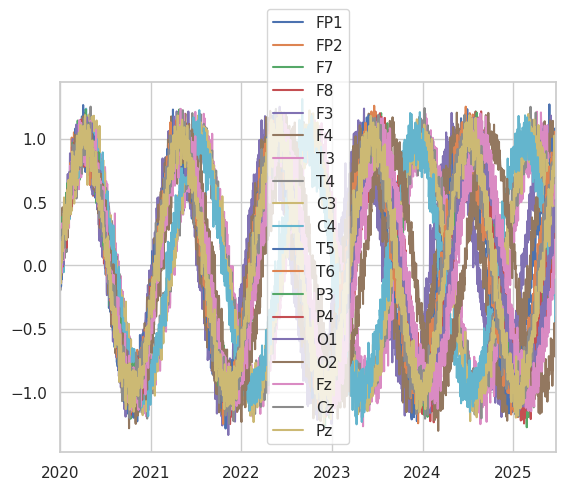

In [13]:
# Datos multivariados

random_row = df.iloc[93]

# Crear un diccionario con las series de cada sensor
sensor_data = {sensor: random_row[sensor] for sensor in sensor_cols}

# Convertir a DataFrame (cada columna es un sensor, cada fila un tiempo)
ts_multivar = pd.DataFrame(sensor_data)

# Crear un índice de tiempo
ts_multivar.index = pd.date_range(start="2020-01-01", periods=len(ts_multivar), freq="D")

ts_multivar # cada valor individual del array está en su propia fila

# Serie temporal por sensor (tenemos 19 sensores)
ts_multivar.plot()

<Axes: >

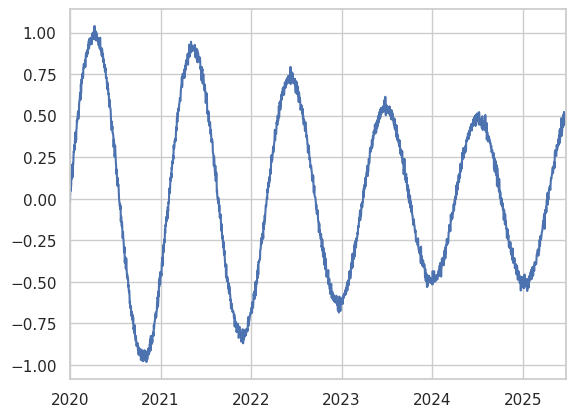

In [14]:
ts.plot()

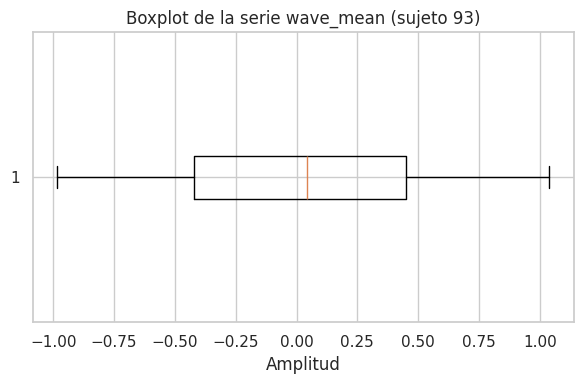

In [15]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

A continuación, se realiza un reescalado de la serie al rango [0,1] para garantizar que todos los valores sean positivos, condición necesaria para aplicar la transformación de Box-Cox. Esta transformación busca estabilizar la varianza y acercar la distribución de los datos a una forma aproximadamente normal, lo cual resulta especialmente útil para modelos lineales y redes neuronales sensibles a la distribución de entrada. Finalmente, se aplica un pequeño desplazamiento hacia arriba para asegurar que todos los valores transformados permanezcan estrictamente positivos y evitar problemas numéricos durante el procesamiento.

<Axes: title={'center': 'Box-Cox (shifted positive)'}>

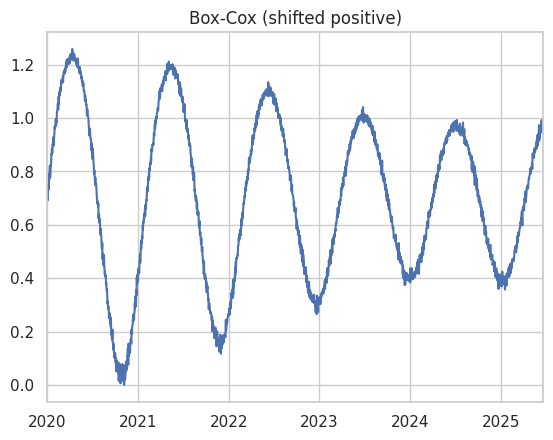

In [16]:
ts_rescaled = (ts + 1) / 2  # Esto asegura que -1 → 0 y 1 → 1
from scipy import stats

ts_boxcox, lambda_ = stats.boxcox(ts_rescaled)
ts_boxcox = pd.Series(ts_boxcox, index=ts.index)

ts_boxcox_shifted = ts_boxcox - ts_boxcox.min() + 1e-5
ts_boxcox_shifted.plot(title="Box-Cox (shifted positive)")

Graficamos de nuevo el box-plot para corroborar la escala del gráfico:

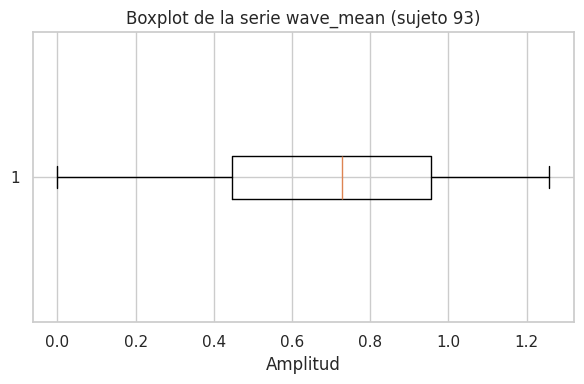

In [17]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts_boxcox_shifted, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

Para evaluar la estacionariedad de la serie de tiempo, se aplica el test de Dickey-Fuller Aumentado (ADF). Esta prueba estadística nos permite verificar si una serie presenta una raíz unitaria, lo que indicaría que es no estacionaria. En términos prácticos, la estacionariedad implica que las propiedades estadísticas de la serie (como la media y la varianza) son constantes a lo largo del tiempo, lo cual es una premisa clave para muchos modelos de pronóstico.

Si el p-valor de la prueba ADF es bajo (generalmente menor a 0.05), podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que indica que la serie es estacionaria. Esto significa que la serie no necesita ser transformada adicionalmente antes de aplicar modelos como ARIMA o redes neuronales.

En cambio, si el p-valor es alto, no podemos rechazar la hipótesis nula y, por lo tanto, la serie se considera no estacionaria. En este caso, puede ser necesario aplicar técnicas adicionales como diferenciación o transformaciones (como el logaritmo o la Box-Cox) para hacer la serie estacionaria antes de continuar con el modelado.

In [18]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [19]:
adf_test(ts_boxcox_shifted)

Results of Dickey-Fuller Test:
Test Statistic                -1.298482e+01
p-value                        2.893004e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


Tras aplicar el test de Dickey-Fuller Aumentado (ADF), se ha confirmado que la serie de tiempo es estacionaria, con un p-valor de 2.89e-24, lo que permite rechazar la hipótesis nula de la presencia de una raíz unitaria. Esto indica que la serie cumple con los requisitos necesarios para aplicar modelos como SARIMAX, los cuales son adecuados para series de tiempo con componentes estacionales y dependencias temporales.

El siguiente paso en el análisis es realizar una descomposición MSTL (Seasonal-Trend decomposition using Loess), que nos permitirá descomponer la serie en sus componentes clave: estacionalidad, tendencia y residuales. Esta descomposición es esencial para entender mejor los patrones subyacentes de la serie y para asegurar que los efectos estacionales sean capturados adecuadamente antes de ajustar el modelo.

Luego de obtener los componentes estacionales, de tendencia y residuales, se realiza nuevamente el test ADF sobre cada uno de ellos para confirmar que no existan problemas de no estacionariedad que puedan afectar la modelización futura. La descomposición no solo facilita una mejor comprensión de la dinámica de la serie, sino que también puede ofrecer pistas sobre qué componentes estacionales deben ser modelados de manera específica en el SARIMAX. Así, aseguramos que el modelo pueda capturar tanto las dependencias de corto plazo como los efectos estacionales, lo que maximiza su capacidad predictiva.

In [20]:
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')

    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

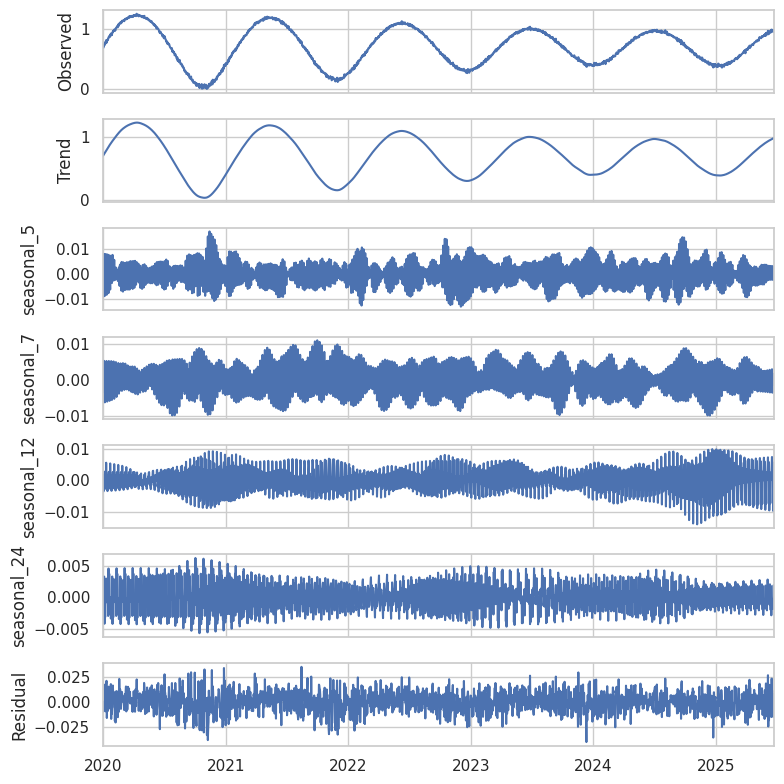

In [21]:
periods_seasonality = (5 ,7 ,12, 24)

desc = mstl_descomposition(ts_boxcox_shifted, periods_seasonality)

In [22]:
# Lista de los componentes estacionales y residuales
components = ['seasonal_5', 'seasonal_7', 'seasonal_12', 'seasonal_24', 'residuals']

# Iterar sobre los componentes y aplicar el test ADF
for component in components:
    print(f"\n{component}")
    # Si el componente no está en 'desc.seasonal', usa 'desc.resid'
    adf_test(desc.seasonal.get(component, desc.resid))
    print()


seasonal_5
Results of Dickey-Fuller Test:
Test Statistic                  -19.202710
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1974.000000
Critical Value (1%)              -3.433667
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64
Stationary


seasonal_7
Results of Dickey-Fuller Test:
Test Statistic                -1.335810e+01
p-value                        5.496851e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                -1.621373e+01
p-value                        3.962143e-29
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -

Con base en estos resultados, podemos concluir que todos los componentes estacionales y los residuos de la serie son estacionarios, lo que significa que la serie de tiempo es adecuada para ser modelada con métodos como SARIMAX, sin necesidad de transformaciones adicionales de diferenciación. La confirmación de la estacionariedad de los residuos es particularmente importante, ya que garantiza que no hay patrones temporales no capturados que puedan influir en el modelo.

Ahora, con la serie ya comprobada como estacionaria, el siguiente paso es realizar un análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los parámetros adecuados del modelo AR (autoregresivo) y MA (media móvil). Esto nos ayudará a ajustar el modelo SARIMAX y a capturar las dependencias temporales y los efectos estacionales de manera más precisa.

In [23]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

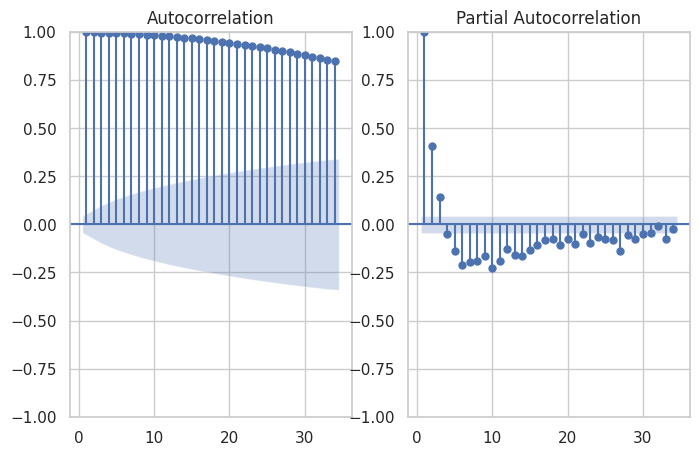

In [24]:
plot_acf_pacf(ts_boxcox_shifted)

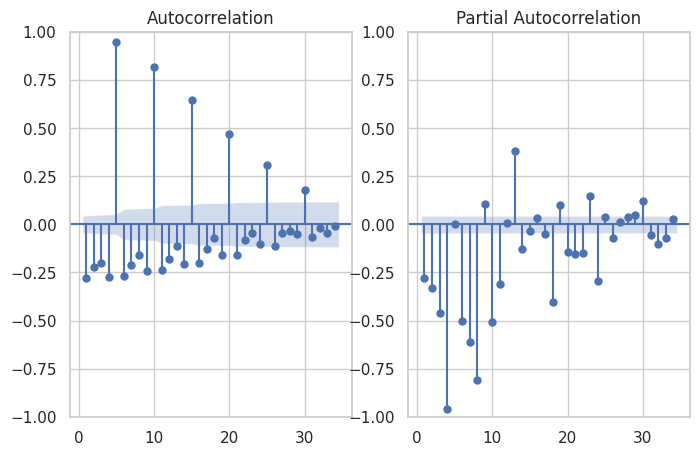

In [25]:
plot_acf_pacf(desc.seasonal['seasonal_5'])

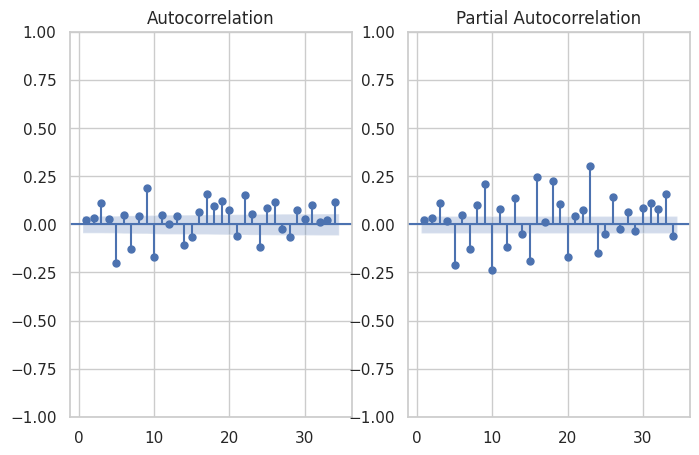

In [26]:
plot_acf_pacf(desc.resid)

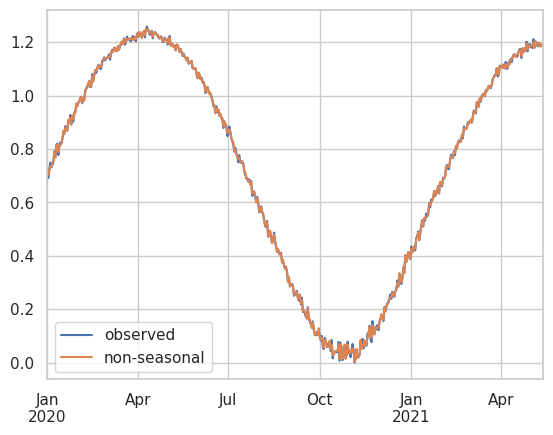

In [27]:
non_seasonal = desc.observed - desc.seasonal['seasonal_5'] - desc.seasonal['seasonal_7']

desc.observed[:500].plot()
non_seasonal[:500].plot()
plt.legend(['observed', 'non-seasonal'])

In [28]:
adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -1.314541e+01
p-value                        1.401610e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


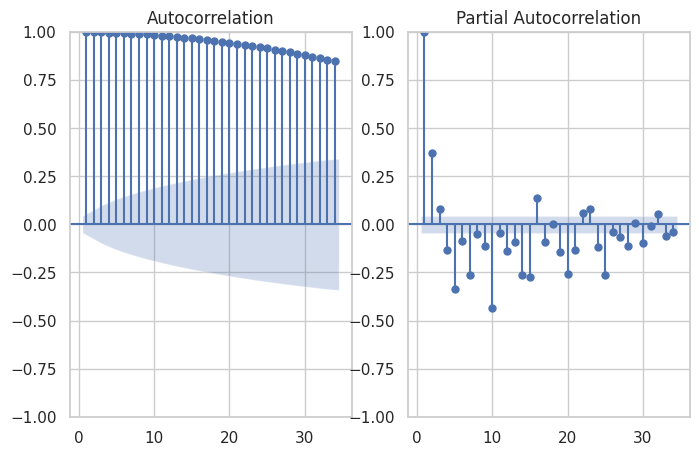

In [29]:
plot_acf_pacf(non_seasonal)

In [31]:
n_train = int(0.8 * len(ts_boxcox_shifted))
n_test = len(ts_boxcox_shifted) - n_train

train_data_opt = ts_boxcox_shifted[:n_train]
test_data_opt = ts_boxcox_shifted[-n_test:]

# Crear características de seno y coseno
ts_sin = np.sin(np.linspace(0, len(train_data_opt), len(train_data_opt)))
ts_cos = np.cos(np.linspace(0, len(train_data_opt), len(train_data_opt)))

# Añadir las características al modelo
train_data_opt = pd.DataFrame({
    'sin_component': ts_sin,
    'cos_component': ts_cos,
    'target': train_data_opt
})

# Crear características de seno y coseno para test
ts_sin_test = np.sin(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))
ts_cos_test = np.cos(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))

test_exog = pd.DataFrame({
    'sin_component': ts_sin_test,
    'cos_component': ts_cos_test
}, index=test_data_opt.index)  # importante mantener el índice

In [32]:
# Suponiendo que `ts` es tu serie temporal
model = SARIMAX(
    train_data_opt['target'],
    exog=train_data_opt[['sin_component', 'cos_component']],
    order=(1, 1, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                 1600
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood                4081.289
Date:                             Thu, 15 May 2025   AIC                          -8142.577
Time:                                     20:01:17   BIC                          -8089.034
Sample:                                 01-01-2020   HQIC                         -8122.671
                                      - 05-18-2024                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sin_component    -0.0002      0.000     -0.686      0.493      -0.001       0.000
cos_component    -

RMSE (Box-Cox): 0.9506
MAE  (Box-Cox): 0.8272


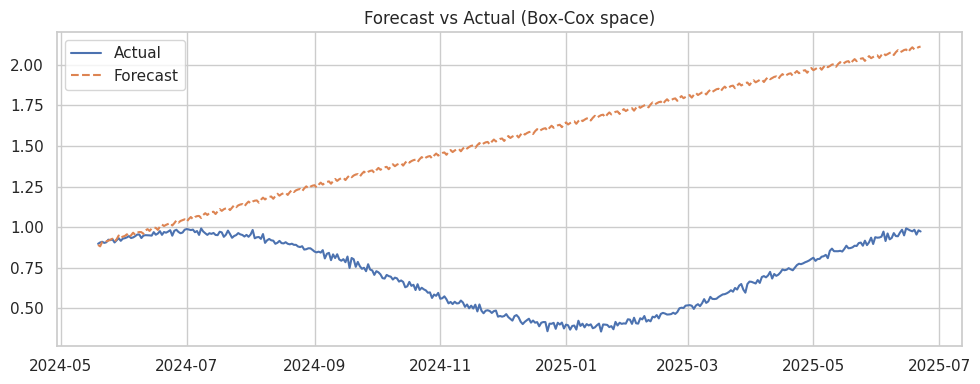

In [33]:
# 2. Predicción
forecast = results.get_forecast(steps=len(test_data_opt), exog=test_exog)
predicted_mean = forecast.predicted_mean

# 3. Evaluación
rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
mae = mean_absolute_error(test_data_opt, predicted_mean)

print(f'RMSE (Box-Cox): {rmse:.4f}')
print(f'MAE  (Box-Cox): {mae:.4f}')

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(test_data_opt.index, test_data_opt, label='Actual')
plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
plt.title('Forecast vs Actual (Box-Cox space)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_data_opt

,sin_component,cos_component,target
2020-01-01,0.000000,1.000000,0.699736
2020-01-02,0.841809,0.539776,0.691375
2020-01-03,0.908776,-0.417284,0.729276
2020-01-04,0.139262,-0.990256,0.748959
2020-01-05,-0.758435,-0.651748,0.731028
...,...,...,...
2024-05-14,0.068377,0.997660,0.882167
2024-05-15,0.876747,0.480952,0.884458
2024-05-16,0.878117,-0.478447,0.867090
2024-05-17,0.071226,-0.997460,0.896977


In [ ]:
test_data_opt

2024-05-19    0.897865
2024-05-20    0.905932
2024-05-21    0.910424
2024-05-22    0.903397
2024-05-23    0.907220
                ...   
2025-06-18    0.974727
2025-06-19    0.984289
2025-06-20    0.954453
2025-06-21    0.980685
2025-06-22    0.973754
Freq: D, Length: 400, dtype: float64

In [ ]:
# Define los rangos máximos (basado en tus valores)
p = [1,2,3]
d = [1,2,3]
q = [1,2,3]

P = [3]
D = [2]
Q = [1]

s = 7  # Periodo estacional

# Generar todas las combinaciones posibles
orders = list(itertools.product(p, d, q))
seasonal_orders = list(itertools.product(P, D, Q))

# Inicializar variables para almacenar el mejor modelo
best_rmse = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Loop de búsqueda
for order in orders:
    for seasonal in seasonal_orders:
        try:
            model = SARIMAX(train_data_opt,
                            order=order,
                            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # 2. Predicción
            forecast = results.get_forecast(steps=len(test_data_opt))
            predicted_mean = forecast.predicted_mean

            # 3. Evaluación
            rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
            mae = mean_absolute_error(test_data_opt, predicted_mean)

            # Mostrar las métricas de rendimiento
            print(f"Modelo SARIMA{order} x {seasonal}7")
            print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

            # Graficar la predicción vs la realidad (en escala Box-Cox)
            plt.figure(figsize=(10, 4))
            plt.plot(test_data_opt.index, test_data_opt, label='Actual')
            plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
            plt.title(f'Forecast vs Actual (SARIMA{order} x {seasonal}7)')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Si el modelo actual tiene un RMSE menor, lo actualizamos como el mejor
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal
                best_model = results
                print(f"NUEVO MEJOR MODELO: SARIMA{order} x {seasonal}7 con RMSE={rmse:.4f}")

        except Exception as e:
            print(f"Error con orden={order} y seasonal={seasonal}: {e}")
            continue

print("\n--- Mejor modelo encontrado ---")
print(f"Orden: {best_order}")
print(f"Orden estacional: {best_seasonal_order}7")
print(f"RMSE: {best_rmse:.4f}")

Error con orden=(1, 1, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (16

## 2. Modelos neuronales para series de tiempo

In [34]:
n_steps_in = 50
n_steps_out = 1

In [35]:
# Callback para todos los modelos
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [36]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    """
    Prepara datos de series de tiempo para predicción.

    Parameters:
        sequences: ndarray de forma (n, ) para univariado o (n, n_features) para multivariado
        n_steps_in: pasos usados como entrada
        n_steps_out: pasos a predecir

    Returns:
        X: entradas de forma (samples, n_steps_in[, n_features])
        y: salidas de forma (samples, n_steps_out[, n_features])
    """
    X, y = [], []
    for i in range(len(sequences) - n_steps_in - n_steps_out + 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#### a) Datos univariados:

In [67]:
data_uni = ts.values

# Crear secuencias
X_uni, y_uni = split_sequences(data_uni, n_steps_in=50, n_steps_out=1)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_uni, y_uni, test_size=0.2, random_state=42, shuffle=False
)

# Formatos para cada arquitectura

# MLP: (samples, 50)
X_train_mlp = X_train
X_test_mlp = X_test
y_train_mlp = y_train
y_test_mlp = y_test

# CNN: (samples, 50, 1)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
y_train_cnn = y_train
y_test_cnn = y_test

# LSTM: (samples, 50, 1)
X_train_lstm = X_train[..., np.newaxis]
X_test_lstm = X_test[..., np.newaxis]
y_train_lstm = y_train
y_test_lstm = y_test

# ConvLSTM2D: (samples, 50, 1, 1, 1)
X_train_convlstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1, 1))
X_test_convlstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1, 1))
y_train_convlstm = y_train
y_test_convlstm = y_test

#### b) Datos multivariados:

In [38]:
data_multi = ts_multivar.values  # shape (2000, 19)

# Dividir en secuencias (ventanas deslizantes)
X_multi, y_multi = split_sequences(data_multi, n_steps_in=50, n_steps_out=1)
# X_multi: (samples, 50, 19)
# y_multi: (samples, 1, 19)

# Dividir en conjunto entrenamiento y prueba (80%-20%)
n_samples = X_multi.shape[0]
split_idx = int(n_samples * 0.8)

X_train_multi = X_multi[:split_idx]
X_test_multi = X_multi[split_idx:]

y_train_multi = y_multi[:split_idx]
y_test_multi = y_multi[split_idx:]

#Preparar datos para cada tipo de modelo

# MLP: aplanar tiempo y características (samples, 50*19)
X_train_mlp_multi = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1] * X_train_multi.shape[2]))
X_test_mlp_multi = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1] * X_test_multi.shape[2]))

# Salidas para MLP (samples, 19)
y_train_mlp_multi = y_train_multi.reshape((y_train_multi.shape[0], y_train_multi.shape[2]))
y_test_mlp_multi = y_test_multi.reshape((y_test_multi.shape[0], y_test_multi.shape[2]))

# CNN: mantener estructura (samples, 50, 19)
X_train_cnn_multi = X_train_multi
X_test_cnn_multi = X_test_multi

# LSTM: igual que CNN
X_train_lstm_multi = X_train_multi
X_test_lstm_multi = X_test_multi

# ConvLSTM2D: reshape a 5D (samples, 50, 1, 19, 1)
X_train_convlstm_multi = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1], 1, X_train_multi.shape[2], 1))
X_test_convlstm_multi = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1], 1, X_test_multi.shape[2], 1))

# Salidas para ConvLSTM2D (samples, 19)
y_train_convlstm_multi = y_train_multi.reshape((y_train_multi.shape[0], y_train_multi.shape[2]))
y_test_convlstm_multi = y_test_multi.reshape((y_test_multi.shape[0], y_test_multi.shape[2]))

#### **Multilayer Perceptron (MLP)**

#### a) Datos univariados:

In [39]:
# Diccionario para guardar resultados
mlp_uni_results = {}
mlp_uni_models = {}

# Modelos MLP univariados
def mlp_uni_model_1(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_uni_model_2(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_uni_model_3(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Diccionario con arquitecturas
mlp_uni_architectures = {
    "MLP_Uni_1": mlp_uni_model_1,
    "MLP_Uni_2": mlp_uni_model_2,
    "MLP_Uni_3": mlp_uni_model_3
}

for name, model_fn in mlp_uni_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_mlp.shape[1],))

    history = model.fit(
        X_train_mlp, y_train_mlp,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_mlp)

    mse = mean_squared_error(y_test_mlp, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_mlp, y_pred)
    r2 = r2_score(y_test_mlp, y_pred)

    mlp_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    mlp_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando MLP_Uni_1...
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1166 - val_loss: 0.0044
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6578e-04 - val_loss: 0.0013
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 12/100
39/39 ━━━━━━━━━━━━━━

#### b) Datos multivariados:

In [40]:
# Diccionarios para guardar resultados y modelos
mlp_multi_results = {}
mlp_multi_models = {}

# Definición de modelos
def mlp_multi_model_1(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(19))  # salida multivariada para 19 sensores
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_multi_model_2(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_multi_model_3(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
mlp_multi_architectures = {
    "MLP_Multi_1": mlp_multi_model_1,
    "MLP_Multi_2": mlp_multi_model_2,
    "MLP_Multi_3": mlp_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in mlp_multi_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_mlp_multi.shape[1],))

    history = model.fit(
        X_train_mlp_multi, y_train_mlp_multi,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_mlp_multi)

    mse = mean_squared_error(y_test_mlp_multi, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_mlp_multi, y_pred)
    r2 = r2_score(y_test_mlp_multi, y_pred)

    mlp_multi_results[name] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    mlp_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando MLP_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2699
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3

#### **Convolutional Neural Network (CNN)**

#### a) Datos univariados:

In [41]:
# Diccionarios para resultados y modelos
cnn_uni_results = {}
cnn_uni_models = {}

# Modelos CNN univariados
def cnn_uni_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_uni_model_2(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_uni_model_3(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
cnn_uni_architectures = {
    "CNN_Uni_1": cnn_uni_model_1,
    "CNN_Uni_2": cnn_uni_model_2,
    "CNN_Uni_3": cnn_uni_model_3
}

for name, model_fn in cnn_uni_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_cnn.shape[1], X_train_cnn.shape[2]))

    history = model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_cnn)

    mse = mean_squared_error(y_test_cnn, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_cnn, y_pred)
    r2 = r2_score(y_test_cnn, y_pred)

    cnn_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    cnn_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando CNN_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0973 - val_loss: 0.0085
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0013
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 8.6551e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9045e-04 - val_loss: 6.6633e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0153e-04 - val_loss: 6.4304e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0236e-04 - val_loss: 6.2648e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8975e-04 - val_loss: 6.5283e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2624e-04 - val_loss: 6.1332e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0293e-04 - val_loss: 6.1137e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0774e-04 - val_loss: 6.2031e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.66

#### b) Datos multivariados:

In [42]:
num_outputs = 19  # Número de salidas (features)

def cnn_multi_model_1(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_multi_model_2(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_multi_model_3(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

cnn_multi_architectures = {
    "CNN_Multi_1": cnn_multi_model_1,
    "CNN_Multi_2": cnn_multi_model_2,
    "CNN_Multi_3": cnn_multi_model_3
}

cnn_multi_results = {}
cnn_multi_models = {}

for name, model_fn in cnn_multi_architectures.items():
    print(f"\nEntrenando {name}...")

    # Input shape para CNN: (50, 19)
    model = model_fn((X_train_cnn_multi.shape[1], X_train_cnn_multi.shape[2]))

    history = model.fit(
        X_train_cnn_multi,
        y_train_multi.reshape((y_train_multi.shape[0], num_outputs)),  # reshape a (samples, 19)
        validation_data=(
            X_test_cnn_multi,
            y_test_multi.reshape((y_test_multi.shape[0], num_outputs))  # reshape a (samples, 19)
        ),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_cnn_multi)

    y_pred_2d = y_pred.reshape(y_pred.shape[0], num_outputs)
    y_true_2d = y_test_multi.reshape(y_test_multi.shape[0], num_outputs)

    mse = mean_squared_error(y_true_2d, y_pred_2d)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_2d, y_pred_2d)
    r2 = r2_score(y_true_2d, y_pred_2d)

    cnn_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    cnn_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando CNN_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2450 - val_loss: 0.0647
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - val_loss: 0.0446
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_loss: 0.0389
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_loss: 0.0388
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168 - val_loss: 0.0359
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165 - val_loss: 0.0333
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0161 - val_loss: 0.0304
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0155 - val_loss: 0.0287
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0154 - val_loss: 0.0266
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 0.0262
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - val_loss: 0.0257
Epoch 12/100
49/49 ━━━━━━━━━━━━━

#### **Long Short-Term Memory (LSTM)**

#### a) Datos univariados:

In [43]:
# Diccionarios para guardar resultados y modelos
lstm_uni_results = {}
lstm_uni_models = {}

# Definición de modelos LSTM univariados
def lstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_uni_architectures = {
    "LSTM_Uni_1": lstm_uni_model_1,
    "LSTM_Uni_2": lstm_uni_model_2,
    "LSTM_Uni_3": lstm_uni_model_3
}

for name, model_fn in lstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_lstm.shape[1], X_train_lstm.shape[2]))

    history = model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_test_lstm, y_test_lstm),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_lstm)

    mse = mean_squared_error(y_test_lstm, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_lstm, y_pred)
    r2 = r2_score(y_test_lstm, y_pred)

    lstm_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    lstm_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando LSTM_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1359 - val_loss: 0.0025
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 6.5187e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - val_loss: 6.4641e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.5118e-04 - val_loss: 7.7259e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.1754e-04 - val_loss: 5.9079e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.7568e-04 - val_loss: 6.4815e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.5037e-04 - val_loss: 6.0708e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.0585e-04 - val_loss: 6.7195e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.8751e-04 - val_loss: 6.3523e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - lo

#### b) Datos multivariados:

In [44]:
num_outputs = 19

# Diccionarios para guardar resultados
lstm_multi_results = {}
lstm_multi_models = {}

# Estructuras de modelos LSTM
def lstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(num_outputs))  # Salida multivariada
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(num_outputs))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_outputs))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_multi_architectures = {
    "LSTM_Multi_1": lstm_multi_model_1,
    "LSTM_Multi_2": lstm_multi_model_2,
    "LSTM_Multi_3": lstm_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in lstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_multi.shape[1], X_train_multi.shape[2]))  # (50, 19)

    history = model.fit(
        X_train_multi,
        y_train_multi.reshape((y_train_multi.shape[0], num_outputs)),  # reshape a (samples, 19)
        validation_data=(
            X_test_multi,
            y_test_multi.reshape((y_test_multi.shape[0], num_outputs))   # reshape a (samples, 19)
        ),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_multi)

    # reshape para métricas
    y_pred_2d = y_pred.reshape(y_pred.shape[0], num_outputs)
    y_true_2d = y_test_multi.reshape(y_test_multi.shape[0], num_outputs)

    mse = mean_squared_error(y_true_2d, y_pred_2d)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_2d, y_pred_2d)
    r2 = r2_score(y_true_2d, y_pred_2d)

    lstm_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    lstm_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando LSTM_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.3572 - val_loss: 0.1563
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0547 - val_loss: 0.0845
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0230 - val_loss: 0.0585
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0164 - val_loss: 0.0489
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0143 - val_loss: 0.0440
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0132 - val_loss: 0.0410
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0124 - val_loss: 0.0385
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0123 - val_loss: 0.0366
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0120 - val_loss: 0.0361
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0117 - val_loss: 0.0327
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0117 - val_loss: 0.0324
Epoch 12/100
49/49 ━━━━━

#### **Conv-LSTM**

#### a) Datos univariados:

In [45]:
# Diccionarios para resultados y modelos
convlstm_uni_results = {}
convlstm_uni_models = {}

def convlstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_uni_architectures = {
    "ConvLSTM_Uni_1": convlstm_uni_model_1,
    "ConvLSTM_Uni_2": convlstm_uni_model_2,
    "ConvLSTM_Uni_3": convlstm_uni_model_3
}

for name, model_fn in convlstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_convlstm.shape[1:])

    history = model.fit(
        X_train_convlstm, y_train_convlstm,
        validation_data=(X_test_convlstm, y_test_convlstm),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_convlstm)

    mse = mean_squared_error(y_test_convlstm, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_convlstm, y_pred)
    r2 = r2_score(y_test_convlstm, y_pred)

    convlstm_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    convlstm_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando ConvLSTM_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1124 - val_loss: 0.0020
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0011 - val_loss: 7.0039e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.0134e-04 - val_loss: 7.4509e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.9508e-04 - val_loss: 6.8299e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.6428e-04 - val_loss: 6.6599e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 6.2257e-04 - val_loss: 7.8937e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.1431e-04 - val_loss: 6.5468e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.2094e-04 - val_loss: 6.8546e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - lo

#### b) Datos multivariados:

In [48]:
# Diccionarios para guardar resultados
convlstm_multi_results = {}
convlstm_multi_models = {}

def convlstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_multi_architectures = {
    "ConvLSTM_Multi_1": convlstm_multi_model_1,
    "ConvLSTM_Multi_2": convlstm_multi_model_2,
    "ConvLSTM_Multi_3": convlstm_multi_model_3
}

for name, model_fn in convlstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_convlstm_multi.shape[1:])  # shape = (50, 1, 19, 1)

    history = model.fit(
        X_train_convlstm_multi, y_train_convlstm_multi,
        validation_data=(X_test_convlstm_multi, y_test_convlstm_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )

    y_pred = model.predict(X_test_convlstm_multi)

    # Métricas
    mse = mean_squared_error(y_test_convlstm_multi, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_convlstm_multi, y_pred)
    r2 = r2_score(y_test_convlstm_multi, y_pred)

    convlstm_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    convlstm_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando ConvLSTM_Multi_1...


KeyboardInterrupt: 

#### **Evaluación y predicciones de los modelos**

##### Selección de los mejores modelos

In [50]:
# PARA VER EN DICCIONARIOS
best_mlp_uni = min(mlp_uni_results, key=lambda k: mlp_uni_results[k]['mse'])
best_cnn_uni = min(cnn_uni_results, key=lambda k: cnn_uni_results[k]['mse'])
best_lstm_uni = min(lstm_uni_results, key=lambda k: lstm_uni_results[k]['mse'])



In [ ]:
# best_convlstm_uni = min(convlstm_uni_results, key=lambda k: convlstm_uni_results[k]['mse'])


In [51]:
print(f"Mejor modelo univariado (MLP, CNN, LSTM): {best_mlp_uni}, {best_cnn_uni}, {best_lstm_uni}")


Mejor modelo univariado (MLP, CNN, LSTM): MLP_Uni_3, CNN_Uni_2, LSTM_Uni_3


In [ ]:
print(f"Mejor modelo univariado (Conv-LSTM): {best_convlstm_uni}")


In [52]:
best_mlp_multi = min(mlp_multi_results, key=lambda k: mlp_multi_results[k]['mse'])
best_cnn_multi = min(cnn_multi_results, key=lambda k: cnn_multi_results[k]['mse'])
best_lstm_multi = min(lstm_multi_results, key=lambda k: lstm_multi_results[k]['mse'])


In [ ]:
#best_convlstm_multi = min(convlstm_multi_results, key=lambda k: convlstm_multi_results[k]['mse'])


In [53]:
print(f"Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_multi}, {best_cnn_multi}, {best_lstm_multi}")

Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Multi_1, CNN_Multi_1, LSTM_Multi_1


In [54]:
print(f"Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): {best_convlstm_multi}")

NameError: name 'best_convlstm_multi' is not defined

In [ ]:
# PARA VER SOLO MÉTRICAS ( YA NO APLICA PORQUE ESTAMOS IMPLEMENTANDO DICCIONARIOS)

# # Selección del mejor modelo univariado (MLP, CNN, LSTM, CONV-LSTM)
# best_mlp_uni = min(mlp_uni_results, key=mlp_uni_results.get)
# best_cnn_uni = min(cnn_uni_results, key=cnn_uni_results.get)
# best_lstm_uni = min(lstm_uni_results, key=lstm_uni_results.get)
# best_convlstm_uni = min(convlstm_uni_results, key=convlstm_uni_results.get)

# # Selección del mejor modelo multivariado (MLP, CNN, LSTM, CONV-LSTM)
# best_mlp_multi = min(mlp_multi_results, key=mlp_multi_results.get)  # Si son float64 está bien
# best_cnn_multi = min(cnn_multi_results, key=lambda k: cnn_multi_results[k]['mse'])
# best_lstm_multi = min(lstm_multi_results, key=lstm_multi_results.get)  # Si son float64 está bien
# best_convlstm_multi = min(convlstm_multi_results, key=convlstm_multi_results.get)  # Si son float64 está bien

# print(f"Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_uni}, {best_cnn_uni}, {best_lstm_uni}, {best_convlstm_uni}")
# print(f"Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_multi}, {best_cnn_multi}, {best_lstm_multi}, {best_convlstm_multi}")

Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Uni_3, CNN_Uni_2, LSTM_Uni_2, ConvLSTM_Uni_2
Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Multi_2, CNN_Multi_2, LSTM_Multi_2, ConvLSTM_Multi_1


##### Predicciones para los modelos neuronales

In [59]:
# Mejor modelo univariado (Ejemplo con MLP)
best_mlp_model_uni = mlp_uni_models[best_mlp_uni]
y_pred_mlp_uni = best_mlp_model_uni.predict(X_test_mlp)

# Mejor modelo multivariado (Ejemplo con MLP)
best_mlp_model_multi = mlp_multi_models[best_mlp_multi]
#y_pred_mlp_multi = best_mlp_model_multi.predict(X_test_multi_mlp)

# Mejor modelo univariado (Ejemplo con CNN)
best_cnn_model_uni = cnn_uni_models[best_cnn_uni]
y_pred_cnn_uni = best_cnn_model_uni.predict(X_test_cnn)

# Mejor modelo multivariado (Ejemplo con CNN)
best_cnn_model_multi = cnn_multi_models[best_cnn_multi]
y_pred_cnn_multi = best_cnn_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con LSTM)
best_lstm_model_uni = lstm_uni_models[best_lstm_uni]
y_pred_lstm_uni = best_lstm_model_uni.predict(X_test_lstm)

# Mejor modelo multivariado (Ejemplo con LSTM)
best_lstm_model_multi = lstm_multi_models[best_lstm_multi]
y_pred_lstm_multi = best_lstm_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con Conv-LSTM)
#best_convlstm_model_uni = convlstm_uni_models[best_convlstm_uni]
#y_pred_convlstm_uni = best_convlstm_model_uni.predict(X_test_convlstm)

# Mejor modelo multivariado (Ejemplo con Conv-LSTM)
#best_convlstm_model_multi = convlstm_multi_models[best_convlstm_multi]
#y_pred_convlstm_multi = best_convlstm_model_multi.predict(X_test_multi_convlstm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


##### Gráficos de las predicciones de los datos univariados

In [60]:
# Graficar predicciones univariadas
plt.figure(figsize=(12, 6))
plt.plot(y_test_uni, label='Valor real', color='blue')
plt.plot(y_pred_mlp_uni, label='Predicción MLP', color='red')
plt.plot(y_pred_cnn_uni, label='Predicción CNN', color='orange')
plt.plot(y_pred_lstm_uni, label='Predicción LSTM', color='purple')
plt.plot(y_pred_convlstm_uni, label='Predicción Conv-LSTM', color='brown')
plt.legend()
plt.title('Comparación de Predicciones: Univariado')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la señal')
plt.show()

NameError: name 'y_test_uni' is not defined

<Figure size 1200x600 with 0 Axes>

##### Gráficos de las predicciones de los datos multivariados

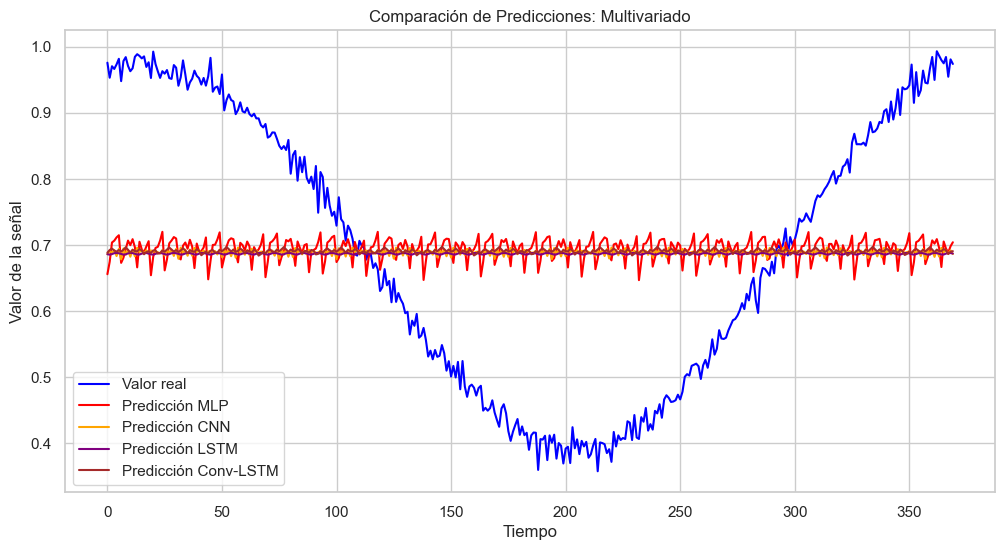

In [ ]:
# Graficar predicciones multivariadas
plt.figure(figsize=(12, 6))
plt.plot(y_test_multi, label='Valor real', color='blue')
plt.plot(y_pred_mlp_multi, label='Predicción MLP', color='red')
plt.plot(y_pred_cnn_multi, label='Predicción CNN', color='orange')
plt.plot(y_pred_lstm_multi, label='Predicción LSTM', color='purple')
plt.plot(y_pred_convlstm_multi, label='Predicción Conv-LSTM', color='brown')
plt.legend()
plt.title('Comparación de Predicciones: Multivariado')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la señal')
plt.show()

##### Optimización con Optuna

In [ ]:
# Ejemplo de optimización para el mejor modelo (MLP Univariado)
def objective(trial):
    model = Sequential()
    model.add(Dense(units=trial.suggest_int('units', 32, 128), activation='relu', input_shape=(X_train_uni_mlp.shape[1],)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_uni_mlp, y_train_uni, validation_data=(X_test_uni_mlp, y_test_uni), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_uni_mlp)
    mse = mean_squared_error(y_test_uni, y_pred)

    return mse

# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor valor de los parámetros
print(f"Mejores parámetros: {study.best_params}")

## 3. Clasificación de series de tiempo

In [159]:
# ----------------------------
# Entrenamiento y evaluación
# ----------------------------
def train_and_eval(model_fn, X_train, X_test, y_train, y_test, nombre):
    print(f"\nEntrenando modelo: {nombre}")
    model = model_fn()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = y_test

    report = classification_report(y_true, y_pred)
    print(f" Reporte de clasificación para {nombre}:\n{report}")

    return report

def train_and_eval2(model_fn, X_train, X_test, y_train, y_test, nombre):
    print(f"\nEntrenando modelo: {nombre}")
    model = model_fn()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    report = classification_report(y_true, y_pred)
    print(f" Reporte de clasificación para {nombre}:\n{report}")

    return report

#### **MLP para clasificación**

#### **CNN para clasificación**

In [125]:
n = 0
u = 0

for i in X_train:
  if len(i) == 2000:
    n += 1
  else:
    u += 1

n, u

(80, 0)

In [114]:
#Train
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    df.wave_mean, df.label, test_size=0.2, random_state=42, shuffle=False
)

In [115]:
import numpy as np

# Convertir X_train a array 2D real (de listas a ndarray)
X_train = np.array([np.array(xi) for xi in X_train], dtype='float32')
X_test = np.array([np.array(xi) for xi in X_test], dtype='float32')

# Verifica que ahora tiene forma (samples, timesteps)
print(X_train.shape)  # debería ser algo como (80, 200)



(80, 2000)


In [116]:
# Ahora sí puedes hacer reshape para Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)  # (80, 200, 1)

(80, 2000, 1)


In [169]:
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dropout

# ----------------------------
# 1. CNN Básica (Conv1D)
# ----------------------------
def basic_cnn():
    model = Sequential([
        Input(shape=(2000, 1)),  # ← Asegúrate que 2000 coincide con tu input
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # O 'softmax' si tienes más clases
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 2. CNN Profunda (Conv2D)
# ----------------------------
def deep_cnn():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(40, 50, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # usa la variable real
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 3. CNN con Dropout (Conv2D)
# ----------------------------
def cnn_with_dropout():
    model = Sequential([
        Conv2D(32, (3, 1), activation='relu', input_shape=(2000, 1, 1)),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(0.25),
        Conv2D(64, (3, 1), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [130]:
acc_basic = train_and_eval(basic_cnn, X_train, X_test, y_train, y_test, "CNN Básica (Conv1D)")


Entrenando modelo: CNN Básica (Conv1D)
Epoch 1/10
3/3 - 2s - 626ms/step - accuracy: 0.4000 - loss: -7.5122e-01
Epoch 2/10
3/3 - 1s - 189ms/step - accuracy: 0.6875 - loss: -8.4381e+00
Epoch 3/10
3/3 - 0s - 101ms/step - accuracy: 0.6875 - loss: -1.8725e+01
Epoch 4/10
3/3 - 0s - 101ms/step - accuracy: 0.6875 - loss: -3.1164e+01
Epoch 5/10
3/3 - 0s - 116ms/step - accuracy: 0.6875 - loss: -4.5771e+01
Epoch 6/10
3/3 - 1s - 181ms/step - accuracy: 0.6875 - loss: -6.4590e+01
Epoch 7/10
3/3 - 1s - 208ms/step - accuracy: 0.6625 - loss: -8.7761e+01
Epoch 8/10
3/3 - 1s - 186ms/step - accuracy: 0.5625 - loss: -1.1284e+02
Epoch 9/10
3/3 - 1s - 177ms/step - accuracy: 0.6750 - loss: -1.4210e+02
Epoch 10/10
3/3 - 1s - 206ms/step - accuracy: 0.6625 - loss: -1.8121e+02


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
 Reporte de clasificación para CNN Básica (Conv1D):
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8

    accuracy                           0.30        20
   macro avg       0.10      0.33      0.15        20
weighted avg       0.09      0.30      0.14        20



In [157]:
# Redimensiona tus datos
X_train_cnn2d = X_train.reshape((X_train.shape[0], 40, 50, 1))
X_test_cnn2d = X_test.reshape((X_test.shape[0], 40, 50, 1))

# Etiquetas one-hot
from keras.utils import to_categorical
num_classes = len(np.unique(y_train))
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

In [162]:
from keras.layers import Conv2D, MaxPooling2D
num_classes = len(np.unique(y_train))
acc_deep = train_and_eval2(deep_cnn, X_train_cnn2d, X_test_cnn2d, y_train_ohe, y_test_ohe, "CNN Profunda (Conv2D)")


Entrenando modelo: CNN Profunda (Conv2D)
Epoch 1/10
3/3 - 7s - 2s/step - accuracy: 0.7250 - loss: 0.7265
Epoch 2/10
3/3 - 1s - 358ms/step - accuracy: 1.0000 - loss: 0.0099
Epoch 3/10
3/3 - 1s - 492ms/step - accuracy: 1.0000 - loss: 9.0821e-06
Epoch 4/10
3/3 - 1s - 318ms/step - accuracy: 1.0000 - loss: 4.4703e-09
Epoch 5/10
3/3 - 1s - 293ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
3/3 - 1s - 284ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
3/3 - 1s - 406ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
3/3 - 1s - 319ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
3/3 - 2s - 526ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
3/3 - 1s - 463ms/step - accuracy: 1.0000 - loss: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
 Reporte de clasificación para CNN Profunda (Conv2D):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
  

In [171]:
acc_dropout = train_and_eval(cnn_with_dropout, X_train, X_test, y_train, y_test, "CNN con Dropout (Conv2D)")


Entrenando modelo: CNN con Dropout (Conv2D)
Epoch 1/10
3/3 - 6s - 2s/step - accuracy: 0.5625 - loss: 0.8118
Epoch 2/10
3/3 - 1s - 321ms/step - accuracy: 1.0000 - loss: 0.0165
Epoch 3/10
3/3 - 1s - 413ms/step - accuracy: 0.9875 - loss: 0.0208
Epoch 4/10
3/3 - 1s - 217ms/step - accuracy: 1.0000 - loss: 5.3824e-05
Epoch 5/10
3/3 - 1s - 458ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 6/10
3/3 - 1s - 223ms/step - accuracy: 1.0000 - loss: 1.5290e-05
Epoch 7/10
3/3 - 1s - 233ms/step - accuracy: 1.0000 - loss: 1.8915e-04
Epoch 8/10
3/3 - 1s - 238ms/step - accuracy: 1.0000 - loss: 1.8387e-04
Epoch 9/10
3/3 - 1s - 423ms/step - accuracy: 1.0000 - loss: 2.9802e-07
Epoch 10/10
3/3 - 1s - 321ms/step - accuracy: 1.0000 - loss: 6.8247e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
 Reporte de clasificación para CNN con Dropout (Conv2D):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
    

#### **LSTM para clasificación**

In [174]:
# ----------------------------
# 1. LSTM
# ----------------------------
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(18286, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [175]:
acc_lstm = train_and_eval(lstm_model, X_train, X_test, y_train, y_test, "LSTM")


Entrenando modelo: LSTM
Epoch 1/10
3/3 - 41s - 14s/step - accuracy: 0.4125 - loss: 1.3931
Epoch 2/10
3/3 - 6s - 2s/step - accuracy: 0.4625 - loss: 1.3719
Epoch 3/10
3/3 - 11s - 4s/step - accuracy: 0.6000 - loss: 1.3595
Epoch 4/10
3/3 - 11s - 4s/step - accuracy: 0.5375 - loss: 1.3461
Epoch 5/10
3/3 - 6s - 2s/step - accuracy: 0.5625 - loss: 1.3151
Epoch 6/10
3/3 - 13s - 4s/step - accuracy: 0.6250 - loss: nan
Epoch 7/10
3/3 - 10s - 3s/step - accuracy: 0.3125 - loss: nan
Epoch 8/10
3/3 - 10s - 3s/step - accuracy: 0.3125 - loss: nan
Epoch 9/10
3/3 - 9s - 3s/step - accuracy: 0.3125 - loss: nan
Epoch 10/10
3/3 - 14s - 5s/step - accuracy: 0.3125 - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
 Reporte de clasificación para LSTM:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8

    accuracy                           0.30    

#### **CNN-LSTM para clasificación**

In [181]:
# ----------------------------
# 1. CNN-LSTM
# ----------------------------
def cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(2000, 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 2. ConvLSTM
# ----------------------------

def conv_lstm_model():
    with tf.device('/GPU:0'):  # Fuerza uso de GPU
        model = Sequential()
        model.add(ConvLSTM2D(64, (3, 1), activation='relu', input_shape=(1, 2000, 1, 1), return_sequences=True))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 1))))
        model.add(ConvLSTM2D(128, (3, 1), activation='relu', return_sequences=False))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation='softmax'))
        model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [184]:
X_train_conv_lstm = X_train.reshape((X_train.shape[0], 1, 2000, 1, 1))
X_test_conv_lstm = X_test.reshape((X_test.shape[0], 1, 2000, 1, 1))

In [185]:
acc_conv_lstm = train_and_eval(conv_lstm_model, X_train_conv_lstm, X_test_conv_lstm, y_train, y_test, "ConvLSTM2D")


Entrenando modelo: ConvLSTM2D
Epoch 1/10
3/3 - 20s - 7s/step - accuracy: 0.6000 - loss: 1.2999
Epoch 2/10
3/3 - 8s - 3s/step - accuracy: 0.9250 - loss: 0.8242
Epoch 3/10
3/3 - 6s - 2s/step - accuracy: 0.9375 - loss: 0.3400
Epoch 4/10
3/3 - 10s - 3s/step - accuracy: 0.9875 - loss: 0.0896
Epoch 5/10
3/3 - 6s - 2s/step - accuracy: 0.9875 - loss: 0.0605
Epoch 6/10
3/3 - 10s - 3s/step - accuracy: 1.0000 - loss: 0.0103
Epoch 7/10
3/3 - 11s - 4s/step - accuracy: 1.0000 - loss: 0.0012
Epoch 8/10
3/3 - 10s - 3s/step - accuracy: 1.0000 - loss: 0.0038
Epoch 9/10
3/3 - 11s - 4s/step - accuracy: 1.0000 - loss: 0.0083
Epoch 10/10
3/3 - 9s - 3s/step - accuracy: 1.0000 - loss: 7.2148e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
 Reporte de clasificación para ConvLSTM2D:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8

    accuracy         

#### **Algoritmos clásicos de Machine Learning (SVM, Random Forest, etc.)**

In [189]:
from sklearn.metrics import accuracy_score
X = np.stack(df.wave_mean.values)  # shape (num_samples, features)

X_train, X_test, y_train, y_test = train_test_split(
    X, df.label.values, test_size=0.2, random_state=42, shuffle=False
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000
K-NN Accuracy: 1.0000
XGBoost Accuracy: 1.0000
